In [1]:
import pydiffvg
import torch
import os

In [2]:
image_path = "../data/test/output_image.jpg"

In [3]:
pydiffvg.set_device(torch.device("cuda"))

# Aesthetic Evaluator Torch


In [4]:
import contextlib
from pathlib import Path

import clip
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch import nn

class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)
    
class AestheticEvaluatorTorch:
    def __init__(self):
        self.model_path = "../models/sac+logos+ava1-l14-linearMSE.pth"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        state_dict = torch.load(self.model_path, weights_only=True, map_location=self.device)

        predictor = AestheticPredictor(768).half()
        predictor.load_state_dict(state_dict)
        predictor.to(self.device)
        predictor.eval()

        clip_model, _ = clip.load(
                "ViT-L/14", device=self.device)
        preprocessor = transforms.Compose(
            [
                transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(224),
                # transforms.Lambda(lambda x: x.clamp_(0, 1)),
                transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            ]
        )
        return predictor, clip_model, preprocessor
    
    def score(self, image: torch.Tensor, no_grad: bool = True):
        if image.ndim != 4:
            raise ValueError(f"image must be 4 channels (shape: {image.shape})")
        
        with torch.no_grad() if no_grad else contextlib.nullcontext():
            image = self.preprocessor(image)
            image_features = self.clip_model.encode_image(image)

            image_features /= image_features.norm(dim=-1, keepdim=True)

            score_tensor = self.predictor(image_features)
        
        return score_tensor / 10



In [5]:
import pydiffvg
import argparse
import ttools.modules
import torch
import skimage.io

gamma = 1.0


In [6]:
import sys
sys.path.append("/home/anhndt/pysvgenius/src")
from optimizer.components.image_processor_torch import ImageProcessorTorch

/home/anhndt/.conda/envs/pysvgenius/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
aesthetic_evaluator = AestheticEvaluatorTorch()

In [9]:
image_processor_torch = ImageProcessorTorch(seed=43).to(device)
image_processor_torch_ref = ImageProcessorTorch(seed=43).to(device)

In [10]:
import skimage.io
import torch.nn.functional as F


target = torch.from_numpy(skimage.io.imread("/home/anhndt/pysvgenius/data/test/Screenshot 2025-05-29 175550.png")).to(torch.float32) / 255.0
target = target.pow(gamma)
target = target.to(pydiffvg.get_device())[:, :, :3]
target = target.unsqueeze(0)
target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
target = F.interpolate(target, size=(384, 384), mode='bilinear', align_corners=False)


In [11]:
target.shape

torch.Size([1, 3, 384, 384])

In [12]:
svg_path = os.path.join("/home/anhndt/pysvgenius/data/test/test_svg.svg")
# svg_path = os.path.join("/home/anhndt/pysvgenius/notebooks/optimized_svg.svg")

canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(svg_path)

In [13]:
points_vars = []
for path in shapes:
    path.points.requires_grad = True
    points_vars.append(path.points)
color_vars = {}
for group in shape_groups:
    group.fill_color.requires_grad = True
    color_vars[group.fill_color.data_ptr()] = group.fill_color
color_vars = list(color_vars.values())

In [14]:
points_optim = torch.optim.Adam(points_vars, lr=1.0)
color_optim = torch.optim.Adam(color_vars, lr=0.01)

In [15]:
loss_list = []

In [16]:
from tqdm import tqdm
num_iter=200

In [17]:
render = pydiffvg.RenderFunction.apply

In [18]:
for _ in tqdm(range(num_iter)):
    points_optim.zero_grad()
    color_optim.zero_grad()

    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups
    )
    
    background = torch.ones((canvas_width, canvas_height, 4), device=device)

    img = (
        render(canvas_width, canvas_height, 2, 2, 0, background, *scene_args)[:, :, :3]
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(device)
    )
    aesthetic = aesthetic_evaluator.score(img)

    # loss = - aesthetic + (img - target_tensor).pow(2).mean()
    loss = (img - target).pow(2).mean()
    loss_list.append(loss.item())
    
    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    points_optim.step()
    color_optim.step()
    for group in shape_groups:
        group.fill_color.data.clamp_(0.0, 1.0)

pydiffvg.save_svg('results.svg',
                            canvas_width, canvas_height, shapes, shape_groups)


100%|██████████| 200/200 [00:08<00:00, 23.59it/s]


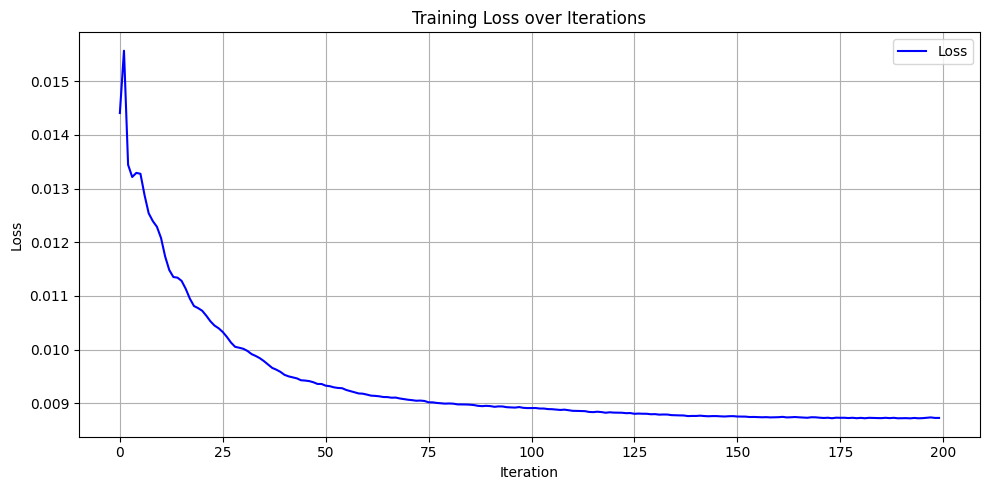

In [19]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Loss', color='blue')
plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
from scour import scour
def optimize_svg(svg):
    options = scour.parse_args([
        '--enable-viewboxing',
        '--enable-id-stripping',
        '--enable-comment-stripping',
        '--shorten-ids',
        '--indent=none',
        '--strip-xml-prolog',
        '--remove-metadata',
        '--remove-descriptive-elements',
        '--disable-embed-rasters',
        '--enable-viewboxing',
        '--create-groups',
        '--renderer-workaround',
        '--set-precision=2',
    ])

    svg = scour.scourString(svg, options)
    
    svg = svg.replace('id=""', '')
    svg = svg.replace('version="1.0"', '')
    svg = svg.replace('version="1.1"', '')
    svg = svg.replace('version="2.0"', '')
    svg = svg.replace('  ', ' ')
    svg = svg.replace('>\n', '>')
    
    return svg

In [ ]:
with open("/home/anhndt/pysvgenius/notebooks/results.svg", 'r') as f:
    svg_str = f.read()

len(svg_str.encode("utf-8"))

38746

In [22]:
optimized_svg = optimize_svg(svg_str)
print(len(optimized_svg.encode('utf-8')))

8283


In [ ]:
with open("optimized_svg.svg", 'w') as f:
    f.write(optimized_svg)

: 